Downloading Data 

In [ ]:
!git clone https://github.com/nirajsoft01/Track1.git

Cloning into 'Track1'...
remote: Enumerating objects: 35795, done.
remote: Total 35795 (delta 0), reused 0 (delta 0), pack-reused 35795
Receiving objects: 100% (35795/35795), 460.07 MiB | 34.07 MiB/s, done.
Checking out files: 100% (36007/36007), done.


In [ ]:
!ls

sample_data  Track1


Image Augmentation library - for creation of More aurgumented image from our training image

In [ ]:
!pip3 install imgaug

Import Required Libraries

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import keras
#import tensorflow.keras as keras              # keras in-built in tensorflow in newer version
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Convolution2D, MaxPooling2D, Dropout, Flatten, Dense
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from google.colab import files
from imgaug import augmenters as iaa
import cv2
import pandas as pd
import ntpath
import random

In [ ]:
datadir = 'Track1'           # to load the track data in data_directory

Pandas Data CSV Insertion

In [ ]:
columns = ['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed']
data = pd.read_csv(os.path.join(datadir, 'driving_log.csv'), names = columns)
data.head()

,center,left,right,steering,throttle,reverse,speed
0,C:\Users\Hp pc\Desktop\Project_DL\Data1\IMG\ce...,C:\Users\Hp pc\Desktop\Project_DL\Data1\IMG\l...,C:\Users\Hp pc\Desktop\Project_DL\Data1\IMG\r...,0.0,0.0,0.0,0.000078
1,C:\Users\Hp pc\Desktop\Project_DL\Data1\IMG\ce...,C:\Users\Hp pc\Desktop\Project_DL\Data1\IMG\l...,C:\Users\Hp pc\Desktop\Project_DL\Data1\IMG\r...,0.0,0.0,0.0,0.000078
2,C:\Users\Hp pc\Desktop\Project_DL\Data1\IMG\ce...,C:\Users\Hp pc\Desktop\Project_DL\Data1\IMG\l...,C:\Users\Hp pc\Desktop\Project_DL\Data1\IMG\r...,0.0,0.0,0.0,0.000078
3,C:\Users\Hp pc\Desktop\Project_DL\Data1\IMG\ce...,C:\Users\Hp pc\Desktop\Project_DL\Data1\IMG\l...,C:\Users\Hp pc\Desktop\Project_DL\Data1\IMG\r...,0.0,0.0,0.0,0.000078
4,C:\Users\Hp pc\Desktop\Project_DL\Data1\IMG\ce...,C:\Users\Hp pc\Desktop\Project_DL\Data1\IMG\l...,C:\Users\Hp pc\Desktop\Project_DL\Data1\IMG\r...,0.0,0.0,0.0,0.000078


In [ ]:
pd.set_option('display.max_colwidth', -1)          #To fit the data according to columns
data.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  """Entry point for launching an IPython kernel.


,center,left,right,steering,throttle,reverse,speed
0,C:\Users\Hp pc\Desktop\Project_DL\Data1\IMG\center_2021_06_04_12_44_42_599.jpg,C:\Users\Hp pc\Desktop\Project_DL\Data1\IMG\left_2021_06_04_12_44_42_599.jpg,C:\Users\Hp pc\Desktop\Project_DL\Data1\IMG\right_2021_06_04_12_44_42_599.jpg,0.0,0.0,0.0,0.000078
1,C:\Users\Hp pc\Desktop\Project_DL\Data1\IMG\center_2021_06_04_12_44_42_738.jpg,C:\Users\Hp pc\Desktop\Project_DL\Data1\IMG\left_2021_06_04_12_44_42_738.jpg,C:\Users\Hp pc\Desktop\Project_DL\Data1\IMG\right_2021_06_04_12_44_42_738.jpg,0.0,0.0,0.0,0.000078
2,C:\Users\Hp pc\Desktop\Project_DL\Data1\IMG\center_2021_06_04_12_44_42_840.jpg,C:\Users\Hp pc\Desktop\Project_DL\Data1\IMG\left_2021_06_04_12_44_42_840.jpg,C:\Users\Hp pc\Desktop\Project_DL\Data1\IMG\right_2021_06_04_12_44_42_840.jpg,0.0,0.0,0.0,0.000078
3,C:\Users\Hp pc\Desktop\Project_DL\Data1\IMG\center_2021_06_04_12_44_42_949.jpg,C:\Users\Hp pc\Desktop\Project_DL\Data1\IMG\left_2021_06_04_12_44_42_949.jpg,C:\Users\Hp pc\Desktop\Project_DL\Data1\IMG\right_2021_06_04_12_44_42_949.jpg,0.0,0.0,0.0,0.000078
4,C:\Users\Hp pc\Desktop\Project_DL\Data1\IMG\center_2021_06_04_12_44_43_062.jpg,C:\Users\Hp pc\Desktop\Project_DL\Data1\IMG\left_2021_06_04_12_44_43_062.jpg,C:\Users\Hp pc\Desktop\Project_DL\Data1\IMG\right_2021_06_04_12_44_43_062.jpg,0.0,0.0,0.0,0.000078


Remove unnecessory Path location 

In [ ]:
def path_leaf(path):
  head, tail = ntpath.split(path)
  return tail
data['center'] = data['center'].apply(path_leaf)
data['left'] = data['left'].apply(path_leaf)
data['right'] = data['right'].apply(path_leaf)
data.head()

,center,left,right,steering,throttle,reverse,speed
0,center_2021_06_04_12_44_42_599.jpg,left_2021_06_04_12_44_42_599.jpg,right_2021_06_04_12_44_42_599.jpg,0.0,0.0,0.0,0.000078
1,center_2021_06_04_12_44_42_738.jpg,left_2021_06_04_12_44_42_738.jpg,right_2021_06_04_12_44_42_738.jpg,0.0,0.0,0.0,0.000078
2,center_2021_06_04_12_44_42_840.jpg,left_2021_06_04_12_44_42_840.jpg,right_2021_06_04_12_44_42_840.jpg,0.0,0.0,0.0,0.000078
3,center_2021_06_04_12_44_42_949.jpg,left_2021_06_04_12_44_42_949.jpg,right_2021_06_04_12_44_42_949.jpg,0.0,0.0,0.0,0.000078
4,center_2021_06_04_12_44_43_062.jpg,left_2021_06_04_12_44_43_062.jpg,right_2021_06_04_12_44_43_062.jpg,0.0,0.0,0.0,0.000078


Grouping or Binning the Dataset

<BarContainer object of 25 artists>

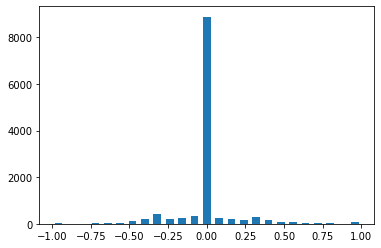

In [ ]:
num_bins = 25
samples_per_bin = 400
hist, bins = np.histogram(data['steering'], num_bins)
center = (bins[:-1]+ bins[1:]) * 0.5
plt.bar(center, hist, width=0.05)

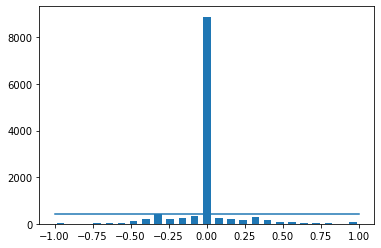

In [ ]:
# Set a boundery limit for balanced -> not biased dataset
num_bins = 25
samples_per_bin = 400
hist, bins = np.histogram(data['steering'], num_bins)
center = (bins[:-1]+ bins[1:]) * 0.5
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

In [ ]:
print('total data:', len(data))                                                                              #coding logic
remove_list = []
for j in range(num_bins):
  list_ = []
  for i in range(len(data['steering'])):
    if data['steering'][i] >= bins[j] and data['steering'][i] <= bins[j+1]:
      list_.append(i)
  list_ = shuffle(list_)
  list_ = list_[samples_per_bin:]
  remove_list.extend(list_)

total data: 12002


In [ ]:
print('removed:', len(remove_list))
data.drop(data.index[remove_list], inplace=True)
print('remaining:', len(data))

removed: 8521
remaining: 3481


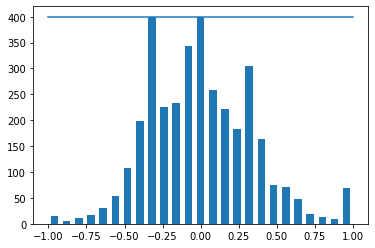

In [ ]:
hist, _ = np.histogram(data['steering'], (num_bins))
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

Train-Test Split

In [ ]:
print(data.iloc[1])

center      center_2021_06_04_12_44_43_170.jpg
left        left_2021_06_04_12_44_43_170.jpg  
right       right_2021_06_04_12_44_43_170.jpg 
steering    0                                 
throttle    0                                 
reverse     0                                 
speed       7.79405e-05                       
Name: 5, dtype: object


In [ ]:
def load_img_steering(datadir, df):
  image_path = []
  steering = []
  for i in range(len(data)):
    indexed_data = data.iloc[i]
    center, left, right = indexed_data[0], indexed_data[1], indexed_data[2]
    # center image append
    image_path.append(os.path.join(datadir, center.strip()))
    steering.append(float(indexed_data[3]))
    # left image append
    image_path.append(os.path.join(datadir,left.strip()))
    steering.append(float(indexed_data[3])+0.15)
    # right image append
    image_path.append(os.path.join(datadir,right.strip()))
    steering.append(float(indexed_data[3])-0.15)
    
  image_paths = np.asarray(image_path)
  steerings = np.asarray(steering)
  return image_paths, steerings

In [ ]:
image_paths, steerings = load_img_steering(datadir + '/IMG', data)

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(image_paths, steerings, test_size=0.2, random_state=6)
print('Training Samples: {}\nValid Samples: {}'.format(len(X_train), len(X_valid)))

Training Samples: 8354
Valid Samples: 2089


Text(0.5, 1.0, 'Validation set')

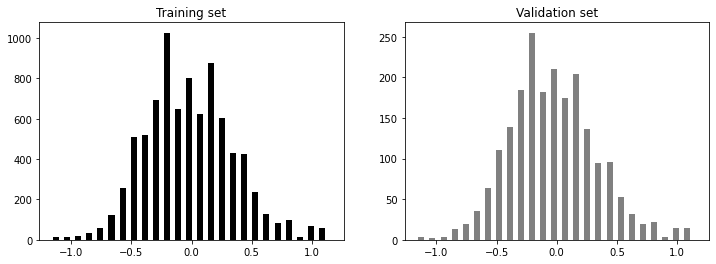

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(y_train, bins=num_bins, width=0.05, color='black')
axes[0].set_title('Training set')
axes[1].hist(y_valid, bins=num_bins, width=0.05, color='gray')
axes[1].set_title('Validation set')

Image Augmentation Techniques - Generating new dataset from existing training dataset

In [ ]:
# Zoom training images to create some new datasets
def zoom(image):
  zoom = iaa.Affine(scale=(1, 1.3))         #scale upto 30% more
  image = zoom.augment_image(image)
  return image

image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
zoomed_image = zoom(original_image)

Text(0.5, 1.0, 'Zoomed Image')

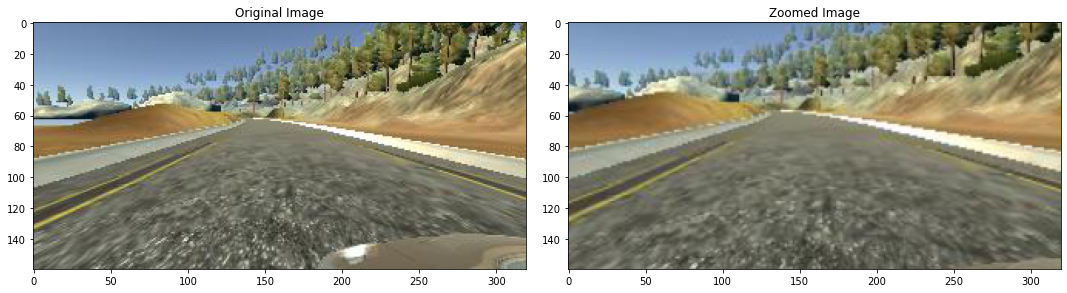

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
 
axs[0].imshow(original_image)
axs[0].set_title('Original Image')
 
axs[1].imshow(zoomed_image)
axs[1].set_title('Zoomed Image')

In [ ]:
# Horizontal or Vertical crop
def pan(image):                     
  pan = iaa.Affine(translate_percent= {"x" : (-0.1, 0.1), "y": (-0.1, 0.1)})
  image = pan.augment_image(image)
  return image
  
image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
panned_image = pan(original_image)

Text(0.5, 1.0, 'Panned Image')

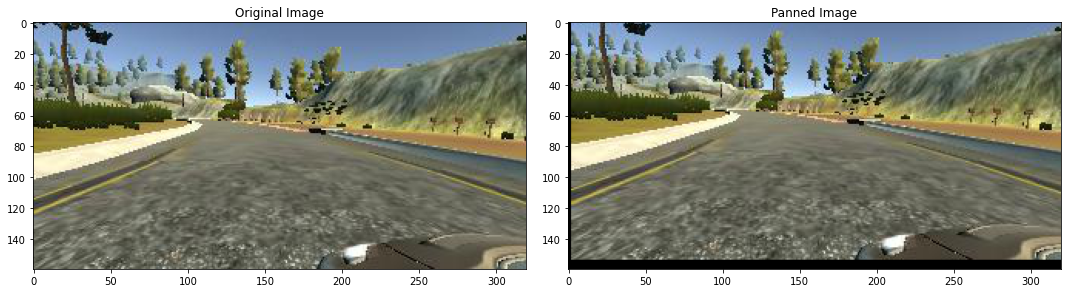

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
 
axs[0].imshow(original_image)
axs[0].set_title('Original Image')
 
axs[1].imshow(panned_image)
axs[1].set_title('Panned Image')

In [ ]:
# add brightness to image for genrate new training image
def img_random_brightness(image):
    brightness = iaa.Multiply((0.2, 1.2))              # low brightness perform better in training process
    image = brightness.augment_image(image)
    return image
    
image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
brightness_altered_image = img_random_brightness(original_image)

Text(0.5, 1.0, 'Brightness altered image ')

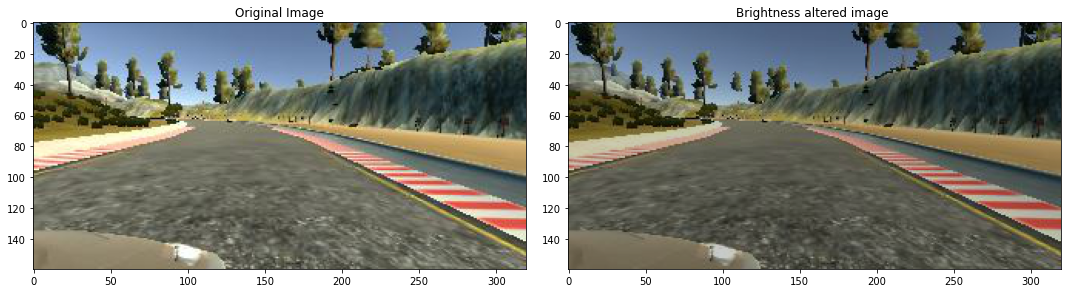

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
 
axs[0].imshow(original_image)
axs[0].set_title('Original Image')
 
axs[1].imshow(brightness_altered_image)
axs[1].set_title('Brightness altered image ')

In [ ]:
# flip the image to genrate more balanced dataset, because our model is skwed to left rather than right
def img_random_flip(image, steering_angle):
    image = cv2.flip(image,1)
    steering_angle = -steering_angle          # also flip steering angles
    return image, steering_angle
random_index = random.randint(0, 1000)
image = image_paths[random_index]
steering_angle = steerings[random_index]
 
original_image = mpimg.imread(image)
flipped_image, flipped_steering_angle = img_random_flip(original_image, steering_angle)

Text(0.5, 1.0, 'Flipped Image - Steering Angle:0.2523624')

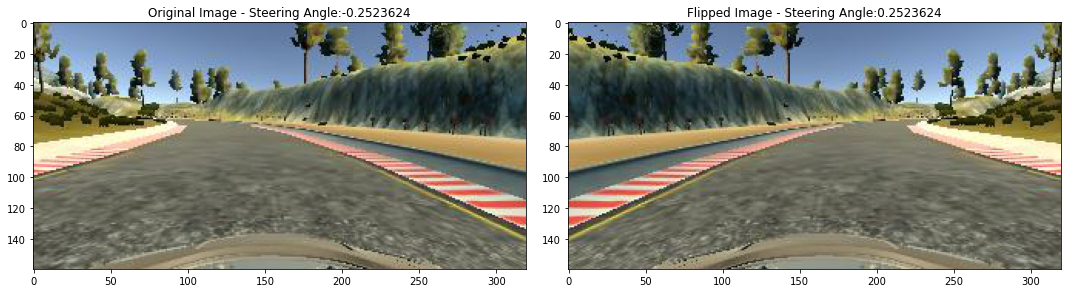

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
 
axs[0].imshow(original_image)
axs[0].set_title('Original Image - ' + 'Steering Angle:' + str(steering_angle))
 
axs[1].imshow(flipped_image)
axs[1].set_title('Flipped Image - ' + 'Steering Angle:' + str(flipped_steering_angle))

In [ ]:
# Capture always 50% of data and genrate random augmented images and repeat this on random effets. 
def random_augment(image, steering_angle):
    image = mpimg.imread(image)
    if np.random.rand() < 0.5:
      image = pan(image)
    if np.random.rand() < 0.5:
      image = zoom(image)
    if np.random.rand() < 0.5:
      image = img_random_brightness(image)
    if np.random.rand() < 0.5:
      image, steering_angle = img_random_flip(image, steering_angle)
    
    return image, steering_angle

In [ ]:
ncol = 2
nrow = 10
 
fig, axs = plt.subplots(nrow, ncol, figsize=(15, 50))
fig.tight_layout()
 
for i in range(10):
  randnum = random.randint(0, len(image_paths) - 1)
  random_image = image_paths[randnum]
  random_steering = steerings[randnum]
    
  original_image = mpimg.imread(random_image)
  augmented_image, steering = random_augment(random_image, random_steering)
    
  axs[i][0].imshow(original_image)
  axs[i][0].set_title("Original Image")
  
  axs[i][1].imshow(augmented_image)
  axs[i][1].set_title("Augmented Image")
 

Output hidden; open in https://colab.research.google.com to view.

Image Preprocessing 

In [ ]:
def img_preprocess(img):
    # img = mpimg.imread(image)  
    img = img[60:135,:,:]                                                            # Crop                   
    img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)                                       # NVIDIA recommended color
    img = cv2.GaussianBlur(img,  (3, 3), 0)                                          # Smoothing Image
    img = cv2.resize(img, (200, 66))                                                 # resize
    img = img/255                                                                    # convert b/w 0--1 
    return img

In [ ]:
image = image_paths[100]
original_image = mpimg.imread(image)
preprocessed_image = img_preprocess(original_image)

Text(0.5, 1.0, 'Preprocessed Image')

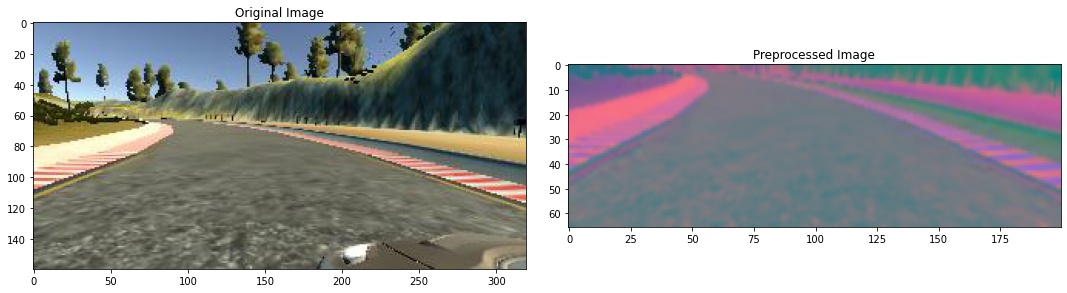

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title('Original Image')
axs[1].imshow(preprocessed_image)
axs[1].set_title('Preprocessed Image')
#plt.grid(True)

In [ ]:
# Batch Genrator - memory efficient
def batch_generator(image_paths, steering_ang, batch_size, istraining):
  
  while True:
    batch_img = []
    batch_steering = []
    
    for i in range(batch_size):
      random_index = random.randint(0, len(image_paths) - 1)
      
      if istraining:
        im, steering = random_augment(image_paths[random_index], steering_ang[random_index])
     
      else:
        im = mpimg.imread(image_paths[random_index])
        steering = steering_ang[random_index]
      
      im = img_preprocess(im)
      batch_img.append(im)
      batch_steering.append(steering)
    yield (np.asarray(batch_img), np.asarray(batch_steering))  

In [ ]:
x_train_gen, y_train_gen = next(batch_generator(X_train, y_train, 1, 1))
x_valid_gen, y_valid_gen = next(batch_generator(X_valid, y_valid, 1, 0))

Text(0.5, 1.0, 'Validation Image')

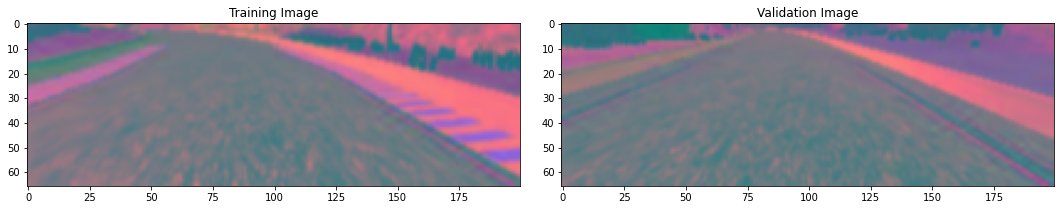

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
 
axs[0].imshow(x_train_gen[0])
axs[0].set_title('Training Image')
 
axs[1].imshow(x_valid_gen[0])
axs[1].set_title('Validation Image')

In [ ]:
#X_train = np.array(list(map(img_preprocess, X_train)))
#X_valid = np.array(list(map(img_preprocess, X_valid)))

In [ ]:
"""
plt.imshow(X_train[random.randint(0, len(X_train - 1))])
plt.axis("off")
print(X_train.shape)

"""

'\nplt.imshow(X_train[random.randint(0, len(X_train - 1))])\nplt.axis("off")\nprint(X_train.shape)\n\n'

### NVIDIA MODEL

In [ ]:
def nvidia_model():
      model = Sequential()
      model.add(Convolution2D(24, kernel_size=(5,5), strides=(2,2), input_shape=(66,200,3),activation='elu'))
      
      model.add(Convolution2D(36, kernel_size=(5,5), strides=(2,2), activation='elu'))
      model.add(Convolution2D(48, kernel_size=(5,5), strides=(2,2), activation='elu'))
      model.add(Convolution2D(64, kernel_size=(3,3), activation='elu'))
      model.add(Convolution2D(64, kernel_size=(3,3), activation='elu'))
      #model.add(Dropout(0.5))
      
      
      model.add(Flatten())

      model.add(Dense(100, activation='elu'))
      #model.add(Dropout(0.5))
      
      model.add(Dense(50, activation='elu'))
      #model.add(Dropout(0.5))

      model.add(Dense(10, activation ='elu'))
      #model.add(Dropout(0.5))

      model.add(Dense(1))      
      
      optimizer= Adam(learning_rate=1e-4)                       #1e-3 = 0.001   1e-4 = 0.0004
      model.compile(loss='mse', optimizer=optimizer)
      
      return model

In [ ]:
model = nvidia_model()

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 47, 36)        21636     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 5, 22, 48)         43248     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 3, 20, 64)         27712     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 1, 18, 64)         36928     
_________________________________________________________________
flatten (Flatten)            (None, 1152)              0         
_________________________________________________________________
dense (Dense)                (None, 100)               1

Using the Data for Model Training

In [ ]:
#history = model.fit(X_train, y_train, epochs= 30, validation_data=(X_valid, y_valid), batch_size=100, verbose=1, shuffle=1)

history = model.fit(batch_generator(X_train, y_train, 100, 1),
                                  steps_per_epoch=300, 
                                  epochs=15,
                                  validation_data=batch_generator(X_valid, y_valid, 100, 0),
                                  validation_steps=200,
                                  verbose=1,
                                  shuffle = 1)

Epoch 1/15
300/300 [==============================] - 443s 1s/step - loss: 0.1178 - val_loss: 0.0880
Epoch 2/15
300/300 [==============================] - 430s 1s/step - loss: 0.0950 - val_loss: 0.0855
Epoch 3/15
300/300 [==============================] - 430s 1s/step - loss: 0.0882 - val_loss: 0.0783
Epoch 4/15
300/300 [==============================] - 430s 1s/step - loss: 0.0815 - val_loss: 0.0751
Epoch 5/15
300/300 [==============================] - 431s 1s/step - loss: 0.0797 - val_loss: 0.0726
Epoch 6/15
300/300 [==============================] - 431s 1s/step - loss: 0.0772 - val_loss: 0.0665
Epoch 7/15
300/300 [==============================] - 430s 1s/step - loss: 0.0754 - val_loss: 0.0684
Epoch 8/15
300/300 [==============================] - 430s 1s/step - loss: 0.0723 - val_loss: 0.0614
Epoch 9/15
300/300 [==============================] - 427s 1s/step - loss: 0.0699 - val_loss: 0.0576
Epoch 10/15
300/300 [==============================] - 427s 1s/step - loss: 0.0700 - val_lo

Analysing Performence of the model

Text(0.5, 0, 'Epoch')

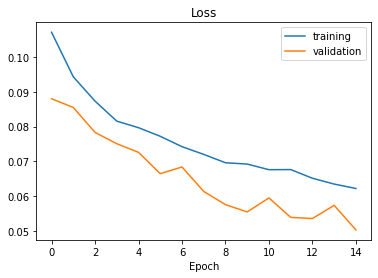

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel('Epoch')

Saving the model into PC

In [ ]:
model.save('model.h5')

In [ ]:
files.download('model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>